## Importing libraries

In [83]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, median_absolute_error
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import re
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pyplot import imread
import imageio
import os
import plotly

#sns.set()
%matplotlib inline

## Extracting Seatle's data

In [2]:
S_calendar_data = pd.read_csv('Seatle_calendar.csv')

In [3]:
S_l_data = pd.read_csv('seatle_listings.csv')

In [4]:
S_reviews_data = pd.read_csv('Seatle_reviews.csv')

## Cleaning the listings data

In [5]:
# Removing url features
col_url = []
for col in S_l_data.columns.tolist():
    if '_url' in col:
        col_url.append(col)

S_l_dropped2 = S_l_data.drop(col_url, axis=1)

**I am removing some features that do not bring contributions to the analysis, either because them don't vary (e.g. state and city), or because they do not make sense in this analysis (such as #id and name).**

In [6]:
S_l_dropped3 = S_l_dropped2.drop(['#id','name','host_id','host_name','host_id','smart_location','state', 
                                  'host_listings_count','street', 'zipcode', 'weekly_price', 'monthly_price',
                                  'host_neighbourhood', 'neighbourhood_group_cleansed','neighbourhood_cleansed','city',
                                 'has_availability','availability_30','availability_60','availability_90',
                                 'availability_365','square_feet','maximum_nights'],axis=1)
cols_boston= ['access','interaction','house_rules']
for col in cols_boston:
    if col in S_l_dropped3.columns.tolist():
        S_l_dropped3 = S_l_dropped3.drop([col],axis=1)

**I create a new variable called host_in_seattle to check if the host is a local, which I believe could bring contributions to the analysis**

In [7]:
S_l_dropped3['host_in_Seattle'] = S_l_dropped3['host_location'].str.contains('Seattle')
S_l_dropped3 = S_l_dropped3.dropna(subset=['host_in_Seattle']).reset_index()
S_l_dropped3['host_in_Seattle'] = pd.Series(S_l_dropped3['host_in_Seattle'].to_numpy(dtype=int))
S_l_dropped3 = S_l_dropped3.drop(['host_location'],axis=1)

**I also transform the dates that are in string format to date format**

In [8]:
r = re.compile('.{4}-.{2}-.{2}')

for col in S_l_dropped3.columns.tolist():
    if S_l_dropped3[col].dtypes == 'O':
        if r.match(S_l_dropped3[col].any()):
            S_l_dropped3[col] = pd.to_datetime(S_l_dropped3[col], errors='ignore')
        else:
            continue

**I will create a variable to check if some features are offered or not. For example, there are some listings that do not inform the "Neighborhood overview", So i will drop the overview and create a boolean variable called "is_there_neighbourhood_overview" to indicate if it was informed.**

In [9]:
col_to_drop2 = ['summary', 'space', 'neighborhood_overview', 'description', 'transit', 'notes', 'host_about']

for col in col_to_drop2:
    S_l_dropped3['isthere_'+col] = ''
    S_l_dropped3['isthere_'+col] = pd.Series(S_l_dropped3[col].isna().to_numpy(dtype=int))


S_l_dropped4 = S_l_dropped3.drop(col_to_drop2, axis=1)


if 'zipcode' in S_l_dropped4.columns.tolist():
    S_l_dropped4['zipcode'] = pd.to_numeric(S_l_dropped4['zipcode'], errors='coerce')

In [10]:
# Removing features which do no vary.
col_to_drop = []
for col in S_l_dropped4.columns.tolist():
    if len(S_l_dropped4[col].unique())==1:
        col_to_drop.append(col)

S_l_dropped4 = S_l_dropped4.drop(col_to_drop, axis=1)

**I'll remove the outliers here**

In [11]:
num_vars1 =  S_l_dropped4.select_dtypes(include=['float', 'int']).columns
for col in num_vars1:
    q = S_l_dropped4[col].quantile(0.99)
    S_l_dropped5 = S_l_dropped4[S_l_dropped4[col]<q]
S_l_dropped5 = S_l_dropped5.reset_index(drop=True)

**I count the number of amenities each listing has.**

**I transform the host verifications into several columns with 1 for present, an 0 for not**

In [12]:
for i in range(S_l_dropped5.shape[0]):
    if '{'  in S_l_dropped5['amenities'][i]:
        S_l_dropped5.loc[i,'amenities'] = S_l_dropped5['amenities'][i].replace('{','')
    if '}' in S_l_dropped5['amenities'][i]:
        S_l_dropped5.loc[i,'amenities'] = S_l_dropped5['amenities'][i].replace('}','')
    if '"' in S_l_dropped5['amenities'][i]:
        S_l_dropped5.loc[i,'amenities'] = S_l_dropped5['amenities'][i].replace('"','')

In [13]:
S_l_amen= S_l_dropped5.copy()
S_l_amen['amenities'] = S_l_dropped5['amenities'].str.split(pat=',')
S_l_amen['number_amenities'] = S_l_amen['amenities'].str.len()

In [14]:
for i in range(S_l_amen.shape[0]):
    if '['  in S_l_amen['host_verifications'][i]:
        S_l_amen.loc[i,'host_verifications'] = S_l_amen['host_verifications'][i].replace('[','')
    if ']' in S_l_dropped5['host_verifications'][i]:
        S_l_amen.loc[i,'host_verifications'] = S_l_amen['host_verifications'][i].replace(']','')
    if '"' in S_l_dropped5['host_verifications'][i]:
        S_l_amen.loc[i,'host_verifications'] = S_l_amen['host_verifications'][i].replace('"','')
    if "'" in S_l_dropped5['host_verifications'][i]:
        S_l_amen.loc[i,'host_verifications'] = S_l_amen['host_verifications'][i].replace("'",'')
    if " " in S_l_dropped5['host_verifications'][i]:
        S_l_amen.loc[i,'host_verifications'] = S_l_amen['host_verifications'][i].replace(" ",'')

all_ver=np.array([])
for i in range(S_l_amen.shape[0]):
    all_ver = np.append(all_ver, S_l_amen['host_verifications'][i].split(','))
    
all_ver = np.unique(all_ver)
all_ver = all_ver[1:] # This is because it created a '' (empty) case, also because there is a 'None' verification

for val in all_ver:
    S_l_amen['verif_' + val] = ''

S_l_amenver = S_l_amen.copy()

for val in all_ver:
    S_l_amenver['verif_'+val] = pd.Series(S_l_amenver['host_verifications'].str.contains(val).to_numpy())

In [15]:
S_l_amenver = S_l_amenver.drop(['host_verifications','amenities','isthere_host_about'],axis=1)

**I also drop any host verification that less than 1% of the listings have (a.k.a. outliers)**

In [16]:
col_to_drop4=[]

for val1 in all_ver:
    if S_l_amenver['verif_' + val1].sum() < int(0.01*S_l_amenver.shape[0]):
        col_to_drop4.append('verif_'+val1)
col_to_drop4
S_l_amenver = S_l_amenver.drop(col_to_drop4,axis=1)

**I make the features with 't' and 'f' values into 1 and 0's.**

In [17]:
col_tf = []
for col in S_l_amenver.columns.tolist():
    if ('f' or 't') in S_l_amenver[col].unique():
        col_tf.append(col)    

for col in col_tf:
    S_l_amenver[col] = S_l_amenver[col].replace(['t','f'],[int(1),int(0)])

C:\Users\Henrique\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



**Here I handle the dates, making them into a difference between dates (ends up as an integer)**

In [18]:
S_l_amenver['host_since'] = (S_l_amenver['host_since']-S_l_amenver['host_since'].min()).dt.days
S_l_amenver['first_review'] = (S_l_amenver['first_review']-S_l_amenver['first_review'].min()).dt.days
S_l_amenver['last_review'] = (S_l_amenver['last_review']-S_l_amenver['last_review'].min()).dt.days

S_l_amenver = S_l_amenver.drop(['calendar_updated'], axis=1)

**There are some numbers that have '$' or '\%' that are seen as strings, so I fix this.**

In [19]:
col_vars = S_l_amenver.select_dtypes(include=['object', 'O']).copy().columns
for col in col_vars:
    if '$' in S_l_amenver[col].any():
        S_l_amenver[col] = S_l_amenver[col].replace('[\$,]', '', regex=True).astype(float)

col_vars2 = S_l_amenver.select_dtypes(include=['object', 'O']).copy().columns
for col in col_vars2:
    if '%' in S_l_amenver[col].any():
        S_l_amenver[col] = S_l_amenver[col].replace('[,\%]','',regex=True).astype(float)

**I define some functions here**

In [20]:
def drop_fill(df,y_data,drop_data):
    """
    df: the pandas dataframe from where the data comes from
    y_data: the string of the dependent variable name
    drop: A list of strings with the features you would like to drop
    
    Outputs:
    X: pandas data without NaN, the independent variables
    y: pandas data without Nan, the dependent variable
    num_vars: list of strings with numerical variables.
    
    This function fills missing values with means for numerical, and mode for categorical data.
    """
    drop_data.append(y_data)
    X = df.drop(drop_data, axis=1)
    y = df[y_data]
    y.fillna((y.mean()), inplace=True)
    
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
    
    cat_vars = X.select_dtypes(include=['object', 'O']).copy().columns
    for var in cat_vars:
        X[var].fillna((X[var].mode()[0]), inplace=True)
    return X, y, num_vars

In [21]:
def make_dummies(df):
    cat_vars = df.select_dtypes(include=['object', 'O']).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    df_2= df.copy()
    return df_2

In [22]:
def vif_dropping(X_data,VIF_lim):
    """
    X_data: pandas data, independent variables without num values.
    VIF_lim: the maximum VIF value allowed to exist
    
    X_out: pandas dataframe without features VIF values above VIF_lim.
    
    This function verifies if there is multicollinearity between independent variables and drops the ones with multicollinearity.
    """
    num_vars2 = X_data.select_dtypes(include=['float', 'int']).columns
    variables = X_data[num_vars2]
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
    vif_val=50
    dropped_col=[]
    while len(vif[vif['VIF']>VIF_lim]) != 0:
        num_vars2 = X_data.select_dtypes(include=['float', 'int']).columns
        vif_val=vif_val-5
        variables = X_data[num_vars2]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
        vif["Features"] = variables.columns
        VIF_clean=vif[vif["VIF"]>vif_val].Features
        X_data = X_data.drop(VIF_clean,axis=1)
        dropped_col.append(VIF_clean)
    X_out = X_data.copy()
    return X_out, dropped_col

In [23]:
def LR_model(X_data,y_data,test_sizee, rdm_state):
    """
    X_data: pandas dataframe with the independent variables
    y_data: pandas dataframe with the dependent variable
    test_sizee: size of the test sample
    rdm_state: random state for randomizer.
    
    y_test: the test targets, as a numpy array.
    y_test_preds: the predicted targets, as a numpy array.
    
    This function standardizes the data, separate it into train and test datasets and then run a linear regression from sklearn.
    """
    scaler = StandardScaler()
    X_scaled = X_data.copy()
    scaler.fit(X_scaled)
    
    X_columns = X_data.columns.tolist()
    X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X_scaled), y_data, test_size = test_sizee, random_state=rdm_state) 
    lm_model = LinearRegression() 
    lm_model.fit(X_train, y_train) 

    y_test_preds = lm_model.predict(X_test) 
    
    return X_columns, X_train, X_test, y_train, y_test, y_test_preds

In [24]:
# Removing features which do no vary.
col_to_drop = []
for col in S_l_amenver.columns.tolist():
    if len(S_l_amenver[col].unique())==1:
        col_to_drop.append(col)

S_l_amenver = S_l_amenver.drop(col_to_drop, axis=1)

## Trying the Linear Model with sklearn

In [25]:
X,y,num_vars = drop_fill(S_l_amenver,'price',['latitude','longitude','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'])
X = make_dummies(X)
X, dropped_col = vif_dropping(X,15)

In [26]:
X_columns, X_train, X_test, y_train, y_test, y_test_preds = LR_model(X,y,0.2,4) 
"The r-squared score for the model using all variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using all variables was 0.6919821570563156 on 592 values.'

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text xticklabel objects>)

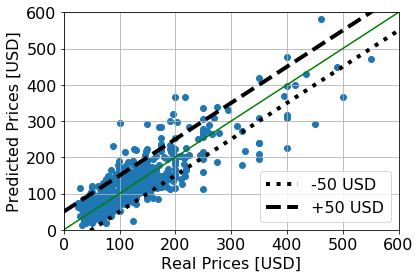

In [27]:
xx = np.arange(0,700,1)
plt.scatter(y_test,y_test_preds)
plt.plot([0,700],[0,700],'g')
plt.plot([0,700],[-50,650],'k:',lw=4,label='-50 USD')
plt.plot([0,700],[50,750],'k--',lw=4,label='+50 USD')
plt.grid(True)
plt.xlabel('Real Prices [USD]',FontSize=16)
plt.ylabel('Predicted Prices [USD]',FontSize=16)
plt.legend(loc='lower right',prop={'size': 16})
plt.xlim(0,600)
plt.ylim(0,600)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

## Trying RandomForest to predict the price

In [28]:
X_columns, X_train, X_test, y_train, y_test, y_test_preds = LR_model(X,y,0.2,4) 

rf = RandomForestRegressor(oob_score = True)
rf.fit(X_train, y_train)

# Predict and score RF
Y_predict = rf.predict(X_test)
rf_testing_set_score = rf.score(X_test, y_test)
rf_mean_abs_error = mean_absolute_error(y_test, y_test_preds)
print('The R^2 score on our testing data is: ' + str(round(rf_testing_set_score,3)))
print('The mean absolute error on our testing data is: ' + str(round(rf_mean_abs_error,3)))

The R^2 score on our testing data is: 0.647
The mean absolute error on our testing data is: 32.191


## Trying Epsilon-Support Vector Regression on the data

In [29]:
clf = SVR(kernel='linear',C=2,epsilon=0.1)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.6862692642486188

## Trying tensorflow for Superhost

In [30]:
"""
I drop all reviews that are not rating, to avoid multicollinearity
"""
X_s,y_s,num_vars = drop_fill(S_l_amenver,'host_is_superhost',['latitude','longitude','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'])
X_s = make_dummies(X_s)
#X_s, dropped_col_s = vif_dropping(X_s,15)
X_s = X_s.reset_index()

In [31]:
scaler = StandardScaler()
X_scaled = X_s.copy()
scaler.fit(X_scaled)
    
X_columns = X_s.columns.tolist()
X_train, X_test, y_train, y_test = train_test_split(scaler.transform(X_scaled), y_s, test_size = 0.2, random_state=42)   

In [32]:
X_train2= pd.DataFrame(data=X_train,columns=X_columns)

In [33]:
BATCH_SIZE = 500
hidden_layer_size = 200
NUM_EPOCHS = 10
output_size = 2

model = tf.keras.Sequential([    
    tf.keras.layers.Dense(hidden_layer_size, activation='relu', input_shape=[len(X_train2.keys())]),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

""" 
Now we have to choose the optimizer and the loss function.

metrics will show us what we are interested in obtaining at each iteration.
"""

#opt = tf.keras.optimizers.Adam(learning_rate=0.1)
sgd = tf.keras.optimizers.SGD(lr=1, decay=1e-3, momentum=0.5, nesterov=False)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=0)

model.fit(X_train2, 
          y_train, 
          batch_size = BATCH_SIZE, 
          epochs = NUM_EPOCHS, 
          #callbacks = [early_stopping],
          validation_split = 0.2,
          verbose =2)

test_loss, test_accuracy = model.evaluate(pd.DataFrame(data=X_test,columns=X_columns),y_test)

# We can apply some nice formatting if we want to
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Train on 1892 samples, validate on 474 samples
Epoch 1/10
1892/1892 - 0s - loss: 1.3785 - accuracy: 0.6253 - val_loss: 0.5931 - val_accuracy: 0.7532
Epoch 2/10
1892/1892 - 0s - loss: 0.5241 - accuracy: 0.7669 - val_loss: 0.4947 - val_accuracy: 0.7532
Epoch 3/10
1892/1892 - 0s - loss: 0.4578 - accuracy: 0.7669 - val_loss: 0.4508 - val_accuracy: 0.7532
Epoch 4/10
1892/1892 - 0s - loss: 0.4117 - accuracy: 0.7674 - val_loss: 0.4290 - val_accuracy: 0.7764
Epoch 5/10
1892/1892 - 0s - loss: 0.3657 - accuracy: 0.8261 - val_loss: 0.4175 - val_accuracy: 0.8038
Epoch 6/10
1892/1892 - 0s - loss: 0.3199 - accuracy: 0.8631 - val_loss: 0.4081 - val_accuracy: 0.8249
Epoch 7/10
1892/1892 - 0s - loss: 0.2820 - accuracy: 0.8906 - val_loss: 0.4562 - val_accuracy: 0.8038
Epoch 8/10
1892/1892 - 0s - loss: 0.2444 - accuracy: 0.9070 - val_loss: 0.4419 - val_accuracy: 0.8354
Epoch 9/10
1892/1892 - 0s - loss: 0.2312 - accuracy: 0.9181 - val_loss: 0.4719 - val_accuracy: 0.8228
Epoch 10/10
1892/1892 - 0s - loss: 

## Logistic regression for Superhost

In [34]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

logisticRegr.fit(X_train2,y_train)

score = logisticRegr.score(X_test, y_test)
print(score)

0.7871621621621622


In [234]:
predictions = logisticRegr.predict(X_test)
reg_summary = pd.DataFrame(X_train2.columns.values, columns=['Features'])
reg_summary['Weights'] = logisticRegr.coef_[0]
reg_summary = reg_summary.set_index('Features')
reg_summary['absolute Weights'] = abs(logisticRegr.coef_[0])
reg_summary = reg_summary.rename(index={
    'review_scores_rating': 'Review scores rating',
    'verif_reviews': 'Verified reviews',
    'reviews_per_month': 'Reviews per month',
    'neighbourhood_Capitol Hill': 'Capitol Hill Neighbourhood',
    'host_response_rate': 'Host response rate',
    'cancellation_policy_strict': 'Strict cancellation policy',
    'last_review': 'Last review',
    'host_in_Seattle': 'Host from Seattle',
    'verif_phone': 'Verified phone',
    'neighbourhood_Fremont': 'Freemont neighbourhood'
})
reg_summary.sort_values(by=['absolute Weights'],ascending=False)[0:50]

,Weights,absolute Weights
Features,,
Review scores rating,1.752393,1.752393
Verified reviews,0.768901,0.768901
calculated_host_listings_count,-0.676250,0.676250
Reviews per month,0.550100,0.550100
neighbourhood_International District,-0.489423,0.489423
Capitol Hill Neighbourhood,0.357202,0.357202
host_response_time_within a day,-0.348328,0.348328
host_response_time_within an hour,-0.341167,0.341167
Host response rate,0.335867,0.335867


## Visualizing the data

**Neighbourhood Airbnb listings**

In [36]:
vis_data = S_l_data.copy()
col_vars = vis_data.select_dtypes(include=['object', 'O']).copy().columns
for col in col_vars:
    if '$' in vis_data[col].any():
        vis_data[col] = vis_data[col].replace('[\$,]', '', regex=True).astype(float)


neighbourhood = vis_data.drop(vis_data.columns.difference(['neighbourhood_group_cleansed','price','latitude','longitude']),axis=1)
mean_price_neighbourhood = neighbourhood.groupby(['neighbourhood_group_cleansed']).mean().sort_values(['price']).reset_index()
mean_price_neighbourhood = mean_price_neighbourhood.rename(columns={"neighbourhood_group_cleansed": "Neighbourhood", 
                                                                    "price": "Price (USD)"})
mean_price_neighbourhood[['Neighbourhood','Price (USD)']]
col_neigh=neighbourhood['neighbourhood_group_cleansed'].unique()
neighbourhood['color_ind'] = ''
for i in range(len(neighbourhood)):
    neighbourhood['color_ind'][i]=np.where(col_neigh==neighbourhood['neighbourhood_group_cleansed'][i])[0]

neighbourhood['color_ind'][0]

C:\Users\Henrique\Anaconda3\envs\py3-TF2.0\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0], dtype=int64)

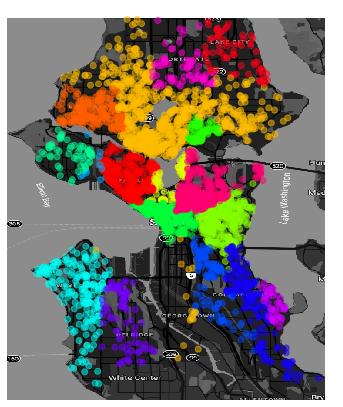

In [200]:
img = imread(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project\Seattle_map2.png')
# get the dimensions
ypixels, xpixels, bands = img.shape
# get the size in inches
dpi = 70.
xinch = xpixels / dpi
yinch = ypixels / dpi

lum_img = img[:,:,0]
plt.use_sticky_edges = False

fig = plt.figure(figsize=(xinch,yinch))
plt.scatter(neighbourhood['longitude'],neighbourhood['latitude'],c=neighbourhood['color_ind'], cmap='hsv', zorder=1,alpha=0.5)
plt.imshow(lum_img, zorder=0, extent=[-122.4357,-122.237,47.495,47.734],alpha=1, cmap="Greys")
plt.axis('off')
plt.margins(x=0.01, y=0.01)
plt.use_sticky_edges = False
#plt.legend(['a','b'])
plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project\Neighbourhood_map.png',bbox_inches="tight")


### The Rise of airbnb in Seattle

In [38]:
S_l_dropped3['host_since']

rise_airbnb=S_l_dropped3.sort_values(by='host_since').copy().reset_index()

**generating the images for the gif**

Now it is commented because it is already generated

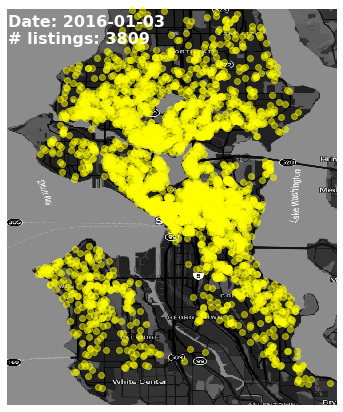

In [209]:
fig = plt.figure(figsize=(xinch,yinch))

plt.imshow(lum_img, zorder=0, extent=[-122.4357,-122.237,47.495,47.734],alpha=1, cmap="Greys")
for i in range(0,len(rise_airbnb)):
    if i>=1:
        textvar.set_visible(False)
        textvar2.set_visible(False)
    plt.scatter(rise_airbnb['longitude'][i],rise_airbnb['latitude'][i], c='yellow', zorder=1,alpha=0.5)
    textvar = plt.text(-122.435,47.723, 'Date: ' + str(rise_airbnb['host_since'][i].date()), fontsize=16, color='w',weight="bold")
    textvar2 = plt.text(-122.435,47.713, '# listings: ' + str(i), fontsize=16, color='w', weight="bold")
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.use_sticky_edges = True
#    
    if i>=2 and rise_airbnb['host_since'][i].month != rise_airbnb['host_since'][i-1].month and i % 2 == 0:
        plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/gif_images/' + 'rise_of_airbnb_' + str(i) +'.png',bbox_inches="tight")
    elif i == len(rise_airbnb):
        plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/gif_images/' + 'rise_of_airbnb_' + str(i) +'.png',bbox_inches="tight")

**Making a gif**

It is commented because the gif is done.

In [210]:
os.chdir(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/gif_images/')
filenames = sorted(filter(os.path.isfile, os.listdir('.')), key=os.path.getmtime)

In [211]:
with imageio.get_writer(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/rise_airbnb.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

## Price analysis in images

In [42]:
price_analysis = neighbourhood.copy()
neigh_price = price_analysis.groupby(['neighbourhood_group_cleansed']).mean().sort_values(['price'],ascending=False).reset_index()
neigh_price = neigh_price[['neighbourhood_group_cleansed','price']]
neigh_price = neigh_price.rename(columns={"neighbourhood_group_cleansed": "Neighbourhood", "price": "Mean Price (USD)"})
neigh_price

,Neighbourhood,Mean Price (USD)
0,Magnolia,177.672131
1,Queen Anne,157.223729
2,Downtown,154.405660
3,West Seattle,141.359606
4,Cascade,140.101124
5,Capitol Hill,130.592593
6,Central Area,128.338753
7,Ballard,124.682609
8,Other neighborhoods,119.968514
9,Interbay,109.727273


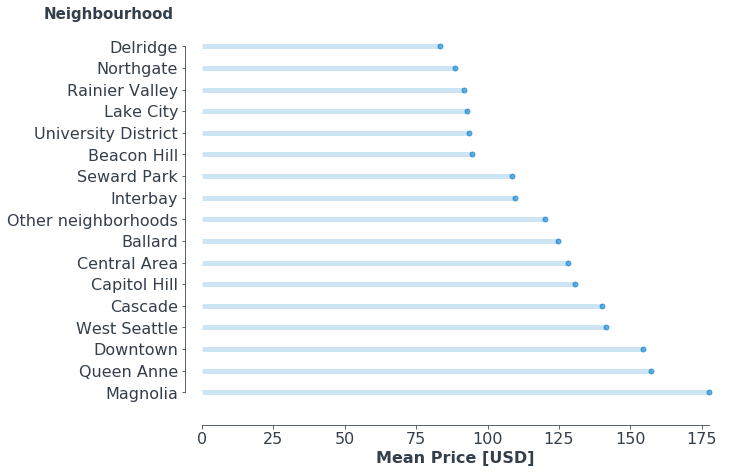

In [165]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(neigh_price.index)+1))

fig, ax = plt.subplots(figsize=(5*2,3.5*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=neigh_price['Mean Price (USD)'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(neigh_price['Mean Price (USD)'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mean Price [USD]', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, neigh_price['Neighbourhood'])

# add an horizonal label for the y axis 
fig.text(-0.06, 0.9, 'Neighbourhood', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))
plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/Neighbourhood_price.png',bbox_inches="tight")

### Price over time

In [235]:
S_cal = S_calendar_data.drop(['#listing_id','available'],axis=1)

**Preprocessing**

In [45]:
r = re.compile('.{4}-.{2}-.{2}')

for col in S_cal.columns.tolist():
    if S_cal[col].dtypes == 'O':
        if r.match(S_cal[col].any()):
            S_cal[col] = pd.to_datetime(S_cal[col], errors='ignore')
        else:
            continue

In [46]:
col_vars = S_cal.select_dtypes(include=['object', 'O']).copy().columns
for col in col_vars:
    if '$' in S_cal[col].any():
        S_cal[col] = S_cal[col].replace('[\$,]', '', regex=True).astype(float)

In [47]:
S_cal = S_cal.dropna().sort_values(['date'],ascending=True).reset_index()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


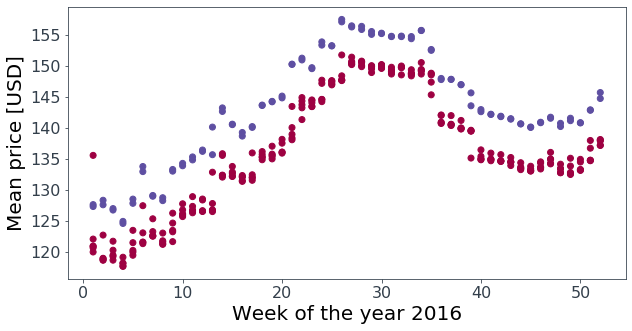

In [48]:
S_cal_mean = S_cal.groupby(['date']).mean().drop(['index'],axis=1).reset_index()
S_cal_mean['weekday'] = S_cal_mean['date'].dt.dayofweek
S_cal_mean['weekend'] = ''


S_cal_mean.loc[S_cal_mean['weekday'] < 4, 'weekend'] = 0
S_cal_mean.loc[S_cal_mean['weekday'] == 6, 'weekend'] = 0
S_cal_mean.loc[S_cal_mean['weekday'] == 4, 'weekend'] = 1
S_cal_mean.loc[S_cal_mean['weekday'] == 5, 'weekend'] = 1

plt.figure(figsize=(10,5))
plt.scatter(S_cal_mean['date'].dt.week,S_cal_mean['price'], c=S_cal_mean['weekend'], cmap='Spectral')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.ylabel('Mean price [USD]',FontSize=20)
plt.xlabel('Week of the year 2016',FontSize=20)
plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/Meanprice_weekoftheyear.png',bbox_inches="tight")

In [49]:
lenD=len(S_cal_mean)

for i in range(1,lenD):
    if S_cal_mean['weekend'][i-1]==1 and S_cal_mean['weekend'][i]==1:
        continue

In [50]:
price_dif = S_cal_mean.groupby(['weekend']).mean().reset_index()
price_dif = price_dif.drop(['weekday','weekend'],axis=1)
price_dif = price_dif.rename(index={0: 'Weekday', 1: 'Weekend'})
price_dif

,price
Weekday,135.853311
Weekend,143.042660


In [91]:
listing_desc = S_l_amenver.describe()

listing_desc = listing_desc[['beds','bathrooms','bedrooms',
                                    'host_since','host_response_rate','host_total_listings_count',
                            'minimum_nights','number_amenities','review_scores_rating',
                             'number_of_reviews','reviews_per_month','cleaning_fee','extra_people','security_deposit','price']]

listing_desc = listing_desc.T
listing_desc = listing_desc.rename(columns={
    'count':'Count',
    'mean':'Mean value',
    'std':'Standard deviation',
    'min':'Minimum value',
    'max':'Maximum value'
}, index={
    'beds': '# of beds',
    'bathrooms': '# of bathrooms',
    'bedrooms': '# of bedrooms',
    'review_scores_rating': 'Review scores rating',
    'price': 'Price (USD)',
    'host_since': '# of days as host',
    'host_response_rate': 'Host response rate',
    'host_total_listings_count': 'Host total listings count',
    'security_deposit': 'Security deposit (USD)',
    'cleaning_fee': 'Cleaning fee (USD)',
    'extra_people': 'Extra price per extra person (USD)',
    'minimum_nights': 'Minimum nights',
    'number_amenities': 'Numbere of amenities',
    'number_of_reviews': 'Number of reviews',
    'reviews_per_month': 'Reviews per month'
})

listing_desc

,Count,Mean value,Standard deviation,Minimum value,25%,50%,75%,Maximum value
# of beds,2957.0,1.750085,1.156308,1.00,1.00,1.00,2.00,15.00
# of bathrooms,2943.0,1.260618,0.586097,0.00,1.00,1.00,1.00,8.00
# of bedrooms,2952.0,1.313347,0.878053,0.00,1.00,1.00,2.00,7.00
# of days as host,2958.0,1665.094320,565.524531,0.00,1285.00,1728.00,2109.00,2609.00
Host response rate,2638.0,95.305534,10.868569,25.00,98.00,100.00,100.00,100.00
Host total listings count,2958.0,7.153144,21.786988,1.00,1.00,1.00,3.00,169.00
Minimum nights,2958.0,2.450642,18.470390,1.00,1.00,2.00,2.00,1000.00
Numbere of amenities,2958.0,14.573022,4.711699,1.00,12.00,14.00,18.00,30.00
Review scores rating,2594.0,94.768697,5.835488,40.00,93.00,96.00,99.00,100.00
Number of reviews,2958.0,26.427654,41.177823,0.00,3.00,12.00,32.00,474.00


### Which types of listings

In [223]:
proptype = S_l_amenver[['property_type','price', 'host_is_superhost']]
proptype2 = proptype.groupby(['property_type']).mean().sort_values(['price'],ascending=False)
proptype2['Count'] = S_l_amenver['property_type'].value_counts()
proptype2 = proptype2.reset_index()
proptype = proptype2.rename(columns={'price':'Mean Price (USD)', 'property_type': 'Property type'})
proptype = proptype.sort_values(['host_is_superhost'],ascending=False)
proptype

,Property type,Mean Price (USD),host_is_superhost,Count
10,Yurt,100.000000,1.000000,1
8,Cabin,109.166667,0.722222,18
4,Treehouse,124.000000,0.500000,2
9,Camper/RV,108.100000,0.400000,10
3,House,129.275911,0.248034,1399
7,Bed & Breakfast,110.542857,0.228571,35
2,Townhouse,133.195652,0.228261,92
5,Apartment,123.825949,0.227057,1264
1,Condominium,145.893939,0.212121,66
6,Loft,119.515152,0.212121,33


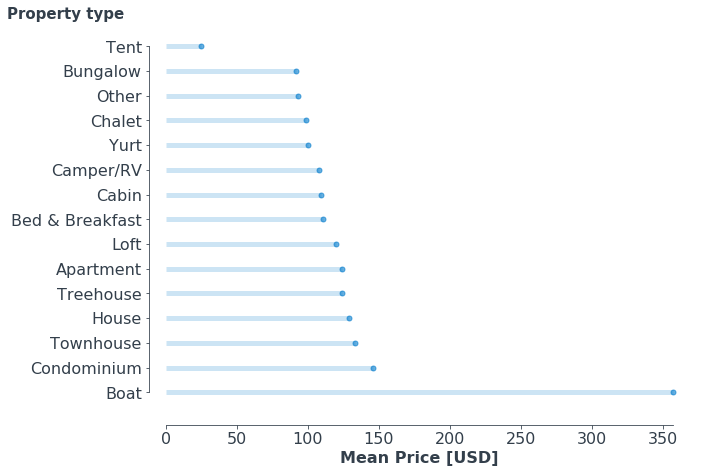

In [220]:
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(proptype.index)+1))

fig, ax = plt.subplots(figsize=(5*2,3.5*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=proptype['Mean Price (USD)'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(proptype['Mean Price (USD)'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Mean Price [USD]', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, proptype['Property type'])

# add an horizonal label for the y axis 
fig.text(-0.06, 0.9, 'Property type', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))
plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/property_type_price.png',bbox_inches="tight")

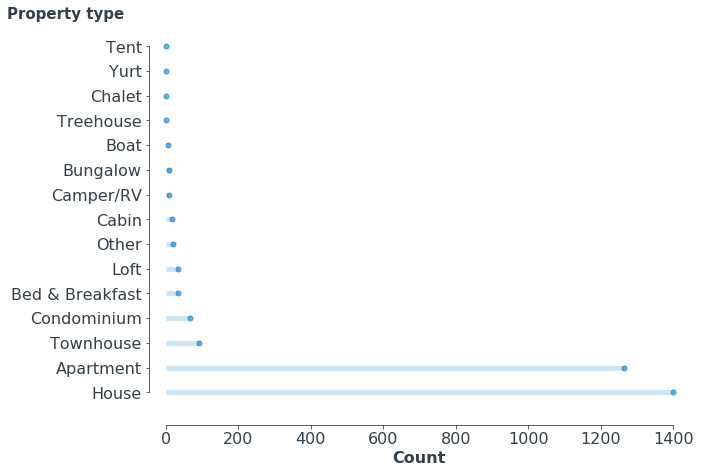

In [216]:
proptype = proptype.sort_values(['Count'],ascending=False)
"""
Making bar plots beautiful
I've used the code from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
as a basis for this plot.
"""

# set font
plt.rcParams['font.family'] = 'DeJaVu Sans'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(proptype.index)+1))

fig, ax = plt.subplots(figsize=(5*2,3.5*2))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=proptype['Count'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(proptype['Count'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Count', fontsize=16, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=16)
plt.yticks(my_range, proptype['Property type'])

# add an horizonal label for the y axis 
fig.text(-0.06, 0.9, 'Property type', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)

# set the spines position
ax.spines['bottom'].set_position(('axes', -0.04))
ax.spines['left'].set_position(('axes', 0.015))
plt.savefig(r'C:\Users\Henrique\Documents\GitHub\Portfolio_under_construction\AirBnB_data_project/property_type_counts.png',bbox_inches="tight")